In [1]:
import numpy as np
import pandas as pd
import sklearn

from scipy import interp
import matplotlib.pyplot as plt
from numpy import ravel

from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

import itertools

import sklearn.metrics as metrics

import matplotlib.pyplot as plt

import random

import scipy

# Set seed
random.seed(53189)
np.random.seed(53189)

In [2]:
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2



def fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight=None):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    sample_weight = None
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes p-value for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    sample_weight = None
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((np.asarray(predictions_one), np.asarray(predictions_two)))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    return 10**calc_pvalue(aucs, delongcov)

In [3]:
A = pd.read_excel("C:/Users/arman/Desktop/Tables/HospitalityNoMortalityICU.xlsx")
print(A.shape)

y = A["hopsitaldays2"]
y = y.ravel()
print(y.shape)

X = A
del X["HospitaldDays..nur.auf.Station."]
del X["hopsitaldays2"]
del X["STS"]
del X["STSACC"]
del X["ID"]
Z = pd.DataFrame(data = X) # Create data frame for colomn names
X = np.array(X, dtype = float)
print(X.shape)

(426, 88)
(426,)
(426, 83)


In [4]:
from sklearn.preprocessing import StandardScaler, Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(X)

feature_scaler = StandardScaler()  
X = feature_scaler.fit_transform(X)

C:\Users\arman\Anaconda3\envs\KerasGPU\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=4)

In [6]:
from sklearn import linear_model
enet = linear_model.SGDClassifier(penalty = 'elasticnet', max_iter=10000, tol=1e-3)

grid_param_enet = {  
    'loss': ['log','hinge','modified_huber'],
    'alpha': [0.1, 0.2, 0.4],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

classifier_enet = GridSearchCV(estimator=enet, param_grid=grid_param_enet, cv=inner_cv, scoring='roc_auc')

In [7]:
enet_fit = classifier_enet.fit(X, y).best_estimator_

C:\Users\arman\Anaconda3\envs\KerasGPU\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [8]:
coefs = pd.concat([pd.DataFrame(Z.columns), pd.DataFrame(np.transpose(enet_fit.coef_))], axis = 1)
coefs

,0,0
0,ValveType,0.000000
1,Size,0.000000
2,Age,0.025829
3,Sex,0.000000
4,BMI,0.000000
5,KHK,0.000000
6,PreTAVISM,0.000000
7,VHF,0.000000
8,HTA,0.000000
9,DM,0.000000


In [9]:
imp = np.where(coefs.values[:,1] != 0)

coefs.values[np.where(coefs.values[:,1] != 0)]

array([['Age', 0.02582931617415394],
       ['PPG', -0.007204331283518818],
       ['NYHA', 0.05361586740375599],
       ['Clostridium', 0.23435425535897042],
       ['Fever', 0.04212716185211591],
       ['Infecition', 0.0052617952877507985],
       ['MaxLeu', 0.03750725614412085],
       ['MaxCRP', 0.06698287858021712],
       ['MaxTNT', 0.1753828025963439],
       ['PQ2', 0.05949649276845513],
       ['major', 0.22213985853043008],
       ['ICUdays', 0.48425470416763094]], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train_small = X_train[:,imp][:,0,:]
X_test_small  = X_test[:,imp][:,0,:]

In [11]:

from sklearn.neural_network import MLPClassifier

NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
grid_param_nn = {  
    'activation': ['logistic','tanh','relu'],
    'solver': ['lbfgs'],
    'learning_rate': ['constant','invscaling'],
    'hidden_layer_sizes':[x for x in itertools.product((3,4,5),repeat=3)]
}

classifier_nn = GridSearchCV(estimator=NeuralNetwork, param_grid=grid_param_nn, cv=inner_cv, scoring='roc_auc')

In [12]:
fit_nn_large   = classifier_nn.fit(X_train, y_train)
probs_nn_large = fit_nn_large.predict_proba(X_test)
fpr_nn_large, tpr_nn_large, thresholds_nn_large = roc_curve(y_test, probs_nn_large[:, 1])
auc_nn_large = auc(fpr_nn_large, tpr_nn_large)

C:\Users\arman\Anaconda3\envs\KerasGPU\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
fit_nn_small   = classifier_nn.fit(X_train_small, y_train)
probs_nn_small = fit_nn_large.predict_proba(X_test_small)
fpr_nn_small, tpr_nn_small, thresholds_nn_small = roc_curve(y_test, probs_nn_small[:, 1])
auc_nn_small   = auc(fpr_nn_small, tpr_nn_small)

C:\Users\arman\Anaconda3\envs\KerasGPU\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


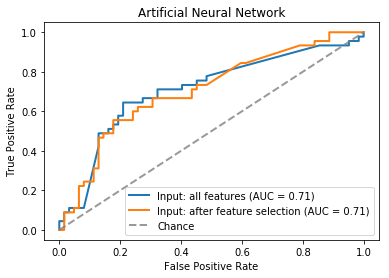

In [14]:
# Plot ROC curve and area under the curve
plt.plot(fpr_nn_large, tpr_nn_large, lw=2, alpha=1,
         label='Input: all features (AUC = %0.2f)' % auc_nn_large)
plt.plot(fpr_nn_small, tpr_nn_small, lw=2, alpha=1, 
         label='Input: after feature selection (AUC = %0.2f)' % auc_nn_small)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         label='Chance', alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Artificial Neural Network')
plt.legend(loc="lower right")
plt.show()

In [15]:
delong_roc_test(y_test, probs_nn_large[:,1], probs_nn_small[:,1])

array([[0.97573366]])

In [16]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

grid_param_rf = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

classifier_rf = GridSearchCV(estimator=rfc, param_grid=grid_param_rf, cv=inner_cv, scoring='roc_auc')

In [17]:
fit_rf_large   = classifier_rf.fit(X_train, y_train)
probs_rf_large = fit_rf_large.predict_proba(X_test)
fpr_rf_large, tpr_rf_large, thresholds_rf_large = roc_curve(y_test, probs_rf_large[:, 1])
auc_rf_large = auc(fpr_rf_large, tpr_rf_large)

In [18]:
fit_rf_small   = classifier_rf.fit(X_train_small, y_train)
probs_rf_small = fit_rf_large.predict_proba(X_test_small)
fpr_rf_small, tpr_rf_small, thresholds_rf_small = roc_curve(y_test, probs_rf_small[:, 1])
auc_rf_small   = auc(fpr_rf_small, tpr_rf_small)

C:\Users\arman\Anaconda3\envs\KerasGPU\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


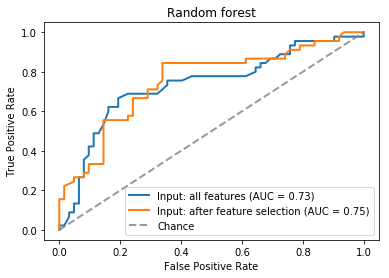

In [19]:
# Plot ROC curve and area under the curve
plt.plot(fpr_rf_large, tpr_rf_large, lw=2, alpha=1,
         label='Input: all features (AUC = %0.2f)' % auc_rf_large)
plt.plot(fpr_rf_small, tpr_rf_small, lw=2, alpha=1, 
         label='Input: after feature selection (AUC = %0.2f)' % auc_rf_small)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         label='Chance', alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random forest')
plt.legend(loc="lower right")
plt.show()

In [20]:
delong_roc_test(y_test, probs_rf_large[:,1], probs_rf_small[:,1])

array([[0.55529057]])

In [21]:
from sklearn import svm, datasets
svc = svm.SVC(probability = True)

grid_param_svm = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma':[.0001, .001, .01]}

classifier_svm = GridSearchCV(estimator=svc, param_grid=grid_param_svm, cv=inner_cv, scoring='roc_auc')

In [22]:
fit_svm_large   = classifier_svm.fit(X_train, y_train)
probs_svm_large = fit_svm_large.predict_proba(X_test)
fpr_svm_large, tpr_svm_large, thresholds_svm_large = roc_curve(y_test, probs_svm_large[:, 1])
auc_svm_large = auc(fpr_svm_large, tpr_svm_large)

C:\Users\arman\Anaconda3\envs\KerasGPU\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
fit_svm_small   = classifier_svm.fit(X_train_small, y_train)
probs_svm_small = fit_svm_large.predict_proba(X_test_small)
fpr_svm_small, tpr_svm_small, thresholds_svm_small = roc_curve(y_test, probs_svm_small[:, 1])
auc_svm_small   = auc(fpr_svm_small, tpr_svm_small)

C:\Users\arman\Anaconda3\envs\KerasGPU\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


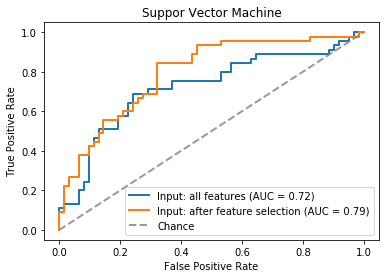

In [24]:
# Plot ROC curve and area under the curve
plt.plot(fpr_svm_large, tpr_svm_large, lw=2, alpha=1,
         label='Input: all features (AUC = %0.2f)' % auc_svm_large)
plt.plot(fpr_svm_small, tpr_svm_small, lw=2, alpha=1, 
         label='Input: after feature selection (AUC = %0.2f)' % auc_svm_small)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         label='Chance', alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Suppor Vector Machine')
plt.legend(loc="lower right")
plt.show()

In [25]:
delong_roc_test(y_test, probs_svm_large[:,1], probs_svm_small[:,1])

array([[0.03003186]])